In [1]:
# Helpful statement for debugging, prints the thing entered as x and the output, i.e.,
# debugPrint(1+1) will output '1+1 [int] = 2'
import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
    
    
import os
import os, sys
# sys.path.append(os.path.join('~/dev/pytorchSPH/', "lib"))
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from tqdm import trange, tqdm
import yaml
%matplotlib notebook
import warnings
warnings.filterwarnings(action='once')
from datetime import datetime

import torch
from torch_geometric.nn import radius
from torch_geometric.nn import SplineConv, fps, global_mean_pool, radius_graph, radius
from torch_scatter import scatter

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [3]:
import tomli

In [ ]:
tomlConfig = """
[particle]
radius = 0.014426521330548324

[simulation]
scheme = "dfsph"

[kernel]
targetNeighbors = 20
defaultKernel = 'wendland2'

[compute]
maxNeighbors = 256
device = 'cuda'
floatprecision = 'single'

[fluid]
restDensity = 1000

[integration]
dt = 0.002

[xsph]
fluidViscosity = 0.01
boundaryViscosity = 0.01

[pressure]
kappa = 1.5
gamma = 7.0

[dfsph]
minDensitySolverIterations = 2
minDivergenceSolverIterations = 2
maxDensitySolverIterations = 256
maxDivergenceSolverIterations = 8
densityThreshold = 1e-4
divergenceThreshold = 1e-2
divergenceSolver = true
backgroundPressure = true
relaxedJacobiOmega = 0.5

[domain]
min = [-2, -1]
max = [6, 1]

[periodicBC]
periodicX = true
periodicY = true
buffer = 2


"""



In [70]:
class Parameter():
    def __init__(self, namespace, name, datatype, defaultValue, required = False, hint = '', export = True):
        self.namespace = namespace
        self.name = name
        self.datatype = datatype
        self.defaultValue = defaultValue
        self.required = required
        self.hint = hint
        self.export = export
        
    def parseConfig(self, config):
        if self.required and self.namespace not in config:
            raise Exception('Parameter Namespace %s missing for required parameter %s.%s' % (self.namespace, self.namespace, self.name))
        elif self.namespace not in config:
            config[self.namespace] = {}
                
        if self.required and self.name not in config[self.namespace]:
            raise Exception('Required parameter %s.%s is missing' % (self.namespace, self.name))
        elif self.name not in config[self.namespace]:
            config[self.namespace][self.name] = self.defaultValue
        
        
            

In [58]:
class dfsph():
    def getParameters():
        
    
    def __init__(self, config):
        print('Loading DFSPH module')
        

IndentationError: expected an indented block (3656034212.py, line 5)

In [60]:
radiusParameter = parameter('particles', 'r', 'float', 0.014426521330548324, required = False, hint = '')

print(parsedConfig)
radiusParameter.parseConfig(parsedConfig)
print(parsedConfig)

{'particle': {'radius': 0.014426521330548324, 'r': 0.014426521330548324}, 'simulation': {'targetNeighbors': 20, 'scheme': 'dfsph'}, 'compute': {'maxNeighbors': 256, 'device': 'cuda', 'floatprecision': 'single', 'precision': torch.float32}, 'fluid': {'restDensity': 1000}, 'integration': {'dt': 0.002}, 'viscosity': {'method': 'xsph', 'xsph': {'fluidViscosity': 0.01, 'boundaryViscosity': 0.01}}, 'pressure': {'kappa': 1.5, 'gamma': 7.0}, 'dfsph': {'minDensitySolverIterations': 2, 'minDivergenceSolverIterations': 2, 'maxDensitySolverIterations': 256, 'maxDivergenceSolverIterations': 8, 'densityThreshold': 0.0001, 'divergenceThreshold': 0.01, 'divergenceSolver': True, 'backgroundPressure': True, 'relaxedJacobiOmega': 0.5}, 'domain': {'min': [-2, -1], 'max': [6, 1]}, 'periodicBC': {'periodicX': True, 'periodicY': True, 'buffer': 2}, 'export': {'active': False, 'prefix': 'fpc'}, 'solidBC': {'obstacle': {'vertices': array([[ 2.50000000e-01,  0.00000000e+00],
       [ 2.30969883e-01,  9.56708581

In [220]:
tomlConfig = """
[xsph]
fluidViscosity = 0.01
boundaryViscosity = 0.01

[pressure]
kappa = 1.5
gamma = 7.0

[dfsph]
minDensitySolverIterations = 2
minDivergenceSolverIterations = 2
maxDensitySolverIterations = 256
maxDivergenceSolverIterations = 8
densityThreshold = 1e-4
divergenceThreshold = 1e-2
divergenceSolver = true
backgroundPressure = true
relaxedJacobiOmega = 0.5

[domain]
min = [-2, -2]
max = [2, 2]
adjustParticle = true
adjustDomain = true

[periodicBC]
periodicX = true
periodicY = true
buffer = 2

[emitter]
[emitter.fluidLeft]
fillDomain = false
min = [-1.5,-0.25]
max = [-1.0, 0.25]
velocity = [ 1.0, 0.0]
[emitter.fluidRight]
fillDomain = false
min = [ 1.0,-0.25]
max = [ 1.5, 0.25]
velocity = [-1.0, 0.0]
"""



In [221]:

def wendland(q, support):
    C = 7 / np.pi
#     print(q)
    
    b1 = torch.pow(1. - q, 4)
#     print(b1)
    b2 = 1.0 + 4.0 * q
#     print(b2)
    return b1 * b2 * C / support**2    

def wendlandGrad(q,r,support):
    C = 7 / np.pi
    
    return - r * C / support**3 * (20. * q * (1. -q)**3)[:,None]
   
    
def getKernelFunctions(kernel):
    if kernel == 'wendland2':
        return wendland, wendlandGrad

In [222]:

from scipy.optimize import minimize

def genParticlesCentered(minCoord, maxCoord, radius, support, packing, dtype = torch.float32, device = 'cpu'):
    area = np.pi * radius**2
    
    gen_position = lambda r, i, j: torch.tensor([r * i, r * j], dtype=dtype, device = device)
        
    diff = maxCoord - minCoord
    center = (minCoord + maxCoord) / 2
    requiredSlices = torch.div(torch.ceil(diff / packing / support).type(torch.int64), 2, rounding_mode='floor')
    
    generatedParticles = []
#     print(requiredSlices)
    for i in range(-requiredSlices[0]-1, requiredSlices[0]+2):
        for j in range(-requiredSlices[1]-1, requiredSlices[1]+2):
            p = center
            g = gen_position(packing * support,i,j)
            pos = p + g
            if pos[0] <= maxCoord[0] + support * 0.2 and pos[1] <= maxCoord[1] + support * 0.2 and \
             pos[0] >= minCoord[0] - support * 0.2 and pos[1] >= minCoord[1] - support * 0.2:
                generatedParticles.append(pos)
                
    return torch.stack(generatedParticles)

def genParticles(minCoord, maxCoord, radius, packing, support, dtype, device):
    with record_function('config - gen particles'):
        area = np.pi * radius**2
#         support = np.sqrt(area * config['targetNeighbors'] / np.pi)
        
        gen_position = lambda r, i, j: torch.tensor([r * i, r * j], dtype=dtype, device = device)
        
    #     packing *= support
        
        diff = maxCoord - minCoord
        requiredSlices = torch.ceil(diff / packing / support).type(torch.int64)
        
    #     print(requiredSlices)
        generatedParticles = []
        for i in range(requiredSlices[0]+1):
            for j in range(requiredSlices[1]+1):
                p = minCoord
                g = gen_position(packing * support,i,j)
                pos = p + g
                if pos[0] <= maxCoord[0] + support * 0.2 and pos[1] <= maxCoord[1] + support * 0.2:
                    generatedParticles.append(pos)
        particles = torch.stack(generatedParticles)

        return particles


In [237]:

from scipy.optimize import minimize
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker

In [224]:
from src.solidBC import *

In [240]:
class torchSPH():
    def getBasicParameters(self):
        basicParticleParameters = [
            Parameter('particle', 'radius', 'float', 0.014426521330548324, required = False, export = True, hint = '')
        ]
        
        basicSimulationParameters = [
            Parameter('simulation', 'scheme', 'string', 'dfsph', required = False, export = True, hint = '')
        ]
        
        basicKernelParameters = [
            Parameter('kernel', 'targetNeighbors', 'int', 20, required = False, export = True, hint = ''),
            Parameter('kernel', 'defaultKernel', 'string', 'wendland2', required = False, export = True, hint = '')
        ]
        
        basicComputeParameters = [
            Parameter('compute', 'maxNeighbors', 'int', 256, required = False, export = True, hint = ''),
            Parameter('compute', 'device', 'string', 'cuda', required = False, export = True, hint = ''),
            Parameter('compute', 'floatprecision', 'string', 'single', required = False, export = True, hint = '')
        ]
        
        basicFluidParameters = [
            Parameter('fluid', 'restDensity', 'float', 1000, required = False, export = True, hint = '')  ,
            Parameter('fluid', 'gravity', 'float array', [0,0], required = False, export = True, hint = '')  ,
        ]
        
        basicIntegrationParameters = [
            Parameter('integration', 'dt', 'float', 0.002, required = False, export = True, hint = '')
        ]
        
        basicViscosityParameters = [
            Parameter('viscosity', 'scheme', 'string', 'xsph', required = False, export = True, hint = '')
        ]
        
        basicDomainParameters = [
            Parameter('domain', 'min', 'float array', [-1, -1], required = False, export = True, hint = ''),
            Parameter('domain', 'max', 'float array', [ 1,  1], required = False, export = True, hint = ''),
            Parameter('domain', 'adjustDomain', 'bool', False,  required = False, export = True, hint = ''),
            Parameter('domain', 'adjustParticle', 'bool', False,  required = False, export = True, hint = '')
        ]
        
        basicExportParameters = [
            Parameter('export', 'active', 'bool', False, required = False, export = True, hint = ''),
            Parameter('export', 'prefix', 'string', 'unnamed', required = False, export = True, hint = '')
        ]
        
        basicPeriodicBCParameters = [
            Parameter('periodicBC', 'periodicX',  'bool', False, required = False, export = True, hint = ''),
            Parameter('periodicBC', 'periodicY',  'bool', False, required = False, export = True, hint = ''),
            Parameter('periodicBC',    'buffer', 'float',     2, required = False, export = True, hint = '')
            
        ]
        
        return basicParticleParameters + basicSimulationParameters + basicKernelParameters + basicComputeParameters + basicFluidParameters + \
            basicIntegrationParameters + basicViscosityParameters + basicDomainParameters + basicExportParameters
    
    
    
    def evalPacking(self, arg):
        packing = torch.tensor(arg, dtype = self.dtype, device = self.device)

        minDomain = torch.tensor([\
                -2 * self.config['particle']['support'],\
                -2 * self.config['particle']['support']\
            ], device = self.device, dtype = self.dtype)
        maxDomain = torch.tensor([\
                 2 * self.config['particle']['support'],\
                 2 * self.config['particle']['support']\
            ], device = self.device, dtype = self.dtype)
        
        fluidPosition = genParticlesCentered(minDomain, maxDomain, \
                            self.config['particle']['radius'], self.config['particle']['support'], packing, \
                            self.dtype, self.device)

        fluidArea = torch.ones(fluidPosition.shape[0], device = self.device, dtype=self.dtype) * self.config['particle']['area']
        centralPosition = torch.tensor([[0,0]], device = self.device, dtype=self.dtype)

        row, col = radius(centralPosition, fluidPosition, \
                          self.config['particle']['support'], max_num_neighbors = self.config['compute']['maxNeighbors'])
        fluidNeighbors = torch.stack([row, col], dim = 0)

        fluidDistances = (centralPosition - fluidPosition[fluidNeighbors[0]])
        fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

        fluidRadialDistances /= self.config['particle']['support']
        rho = scatter(\
                self.kernel(fluidRadialDistances, self.config['particle']['support']) * fluidArea[fluidNeighbors[1]], \
                fluidNeighbors[1], dim=0, dim_size=centralPosition.size(0), reduce="add")

        return ((1 - rho)**2).detach().cpu().numpy()[0]

    def evalSpacing(self, arg):
        s = torch.tensor(arg, dtype=self.dtype, device = self.device)
        support = self.config['particle']['support']

        minDomain = torch.tensor([\
                -2 * self.config['particle']['support'],\
                -2 * self.config['particle']['support']\
            ], device = self.device, dtype = self.dtype)
        maxDomain = torch.tensor([\
                 2 * self.config['particle']['support'],\
                 2 * self.config['particle']['support']\
            ], device = self.device, dtype = self.dtype)
        
        fluidPosition = genParticlesCentered(minDomain, maxDomain, \
                            self.config['particle']['radius'], self.config['particle']['support'], \
                            self.config['particle']['packing'],self.dtype, self.device)
        
        fluidPosition = fluidPosition[fluidPosition[:,1] >= 0,:]
        centralPosition = torch.tensor([[0,0]], dtype = self.dtype, device=self.device)

        row, col = radius(centralPosition, fluidPosition, support, max_num_neighbors = self.config['compute']['maxNeighbors'])
        fluidNeighbors = torch.stack([row, col], dim = 0)

        fluidDistances = (centralPosition - fluidPosition[fluidNeighbors[0]])
        fluidRadialDistances = torch.linalg.norm(fluidDistances,axis=1)

        fluidRadialDistances /= support
        rho = scatter(self.kernel(fluidRadialDistances, support) * self.config['particle']['area'], fluidNeighbors[1], dim=0, dim_size=centralPosition.size(0), reduce="add")

        sdf, sdfGrad, b, bGrad = sdPolyDerAndIntegral(\
                torch.tensor([\
                    [ -support * 2, -support * 2],\
                    [  support * 2, -support * 2],\
                    [  support * 2,  s * support],\
                    [ -support * 2,  s * support],\
                             ], dtype= self.dtype, device = self.device),\
                p = centralPosition, support = support
        )

        return ((1- (rho + b))**2).detach().cpu().numpy()[0]
        
        
    def evalContrib(self):
        s = torch.tensor(self.config['particle']['spacing'], dtype=self.dtype, device = self.device)
        centralPosition = torch.tensor([[0,0]], dtype=self.dtype, device = self.device)

        support = self.config['particle']['support']
        
        sdf, sdfGrad, b, bGrad = sdPolyDerAndIntegral(\
                torch.tensor([\
                    [ -support * 2, -support * 2],\
                    [  support * 2, -support * 2],\
                    [  support * 2,  s * support],\
                    [ -support * 2,  s * support],\
                             ], dtype=self.dtype, device = self.device),\
                p = centralPosition, support = support
        )

        return b

    def processVelocitySources(self):
        if 'velocitySource' not in self.config:
            return
        for source in self.config['velocitySource']:
#             print(emitter)
            source[ 'rampTime'] = emitter['rampTime'] if 'rampTime' in emitter else 1.0
            if 'min' not in emitter:
                raise Exception('Provided velocity source has no min extent, configuration invalid')
            if 'max' not in emitter:
                raise Exception('Provided velocity source has no max extent, configuration invalid')
            if 'velocity' not in emitter:
                raise Exception('Provided velocity source has no velocity, configuration invalid')
    
    def processEmitters(self):
        if 'emitter' not in self.config:
            return
        
        minCompression = self.config['compute']['maxValue']
        
        for emitterName in self.config['emitter']:
#             print(emitter)
            print('processing emitter %s' % emitterName)
            emitter = self.config['emitter'][emitterName]
            emitter[ 'fillDomain'] = False if 'fillDomain' not in emitter else emitter['fillDomain']
            if emitter['fillDomain']:
                if 'min' in emitter or 'max' in emitter:
                    raise Exception('Extent provided for fillDomain emitter, configuration invalid')
                    
                spacing = self.config['particle']['spacing'] * self.config['particle']['support']
                packing = self.config['particle']['packing'] * self.config['particle']['support']

                emitter[        'min'] = [self.config['domain']['min'][0] + packing / 2, self.config['domain']['min'][1] + packing /2]
                emitter[        'max'] = [self.config['domain']['max'][0] - packing / 2, self.config['domain']['max'][1] - packing / 2]
                    
            else:
                if 'min' not in emitter or 'max' not in emitter:
                    raise Exception('Extent not provided for emitter, configuration invalid')
                
            emitter[     'radius'] = emitter['radius'] if 'radius' in emitter else self.config['particle']['radius']
            emitter['restDensity'] = emitter['restDensity'] if 'restDensity' in emitter else self.config['fluid']['restDensity']
            emitter[       'type'] = emitter['type'] if 'type' in emitter else 'once'
            emitter['compression'] = emitter['compression'] if 'compression' in emitter else 1.
            emitter[   'velocity'] = emitter['velocity'] if 'velocity' in emitter else [0.0,0.0]
                        
            minCompression = min(minCompression, emitter['compression'])
    
    def addBoundaryBoundaries(self):
        if self.config['periodicBC']['periodicX'] and self.config['periodicBC']['periodicY']:
            return
        if 'solidBC' not in self.config:
            self.config['solidBC'] = {}
        if self.config['periodicBC']['periodicX'] and not self.config['periodicBC']['periodicY']:
            minDomain = self.config['domain']['virtualMin']
            maxDomain = self.config['domain']['virtualMax']
            buffer = self.config['particle']['support'] * self.config['periodicBC']['buffer']

            config['solidBoundary']['bottomBoundary'] = {
                'vertices':[
                    [minDomain[0],minDomain[1]],
                    [maxDomain[0],minDomain[1]],
                    [maxDomain[0],minDomain[1] + buffer],
                    [minDomain[0],minDomain[1] + buffer]
                ],
                'inverted':False
            }
            config['solidBoundary']['topBoundary'] = {
                'vertices':[
                    [minDomain[0],maxDomain[1] - buffer],
                    [maxDomain[0],maxDomain[1] - buffer],
                    [maxDomain[0],maxDomain[1]],
                    [minDomain[0],maxDomain[1]]
                ],
                'inverted':False
            }
        if not self.config['periodicBC']['periodicX'] and self.config['periodicBC']['periodicY']:
            minDomain = self.config['domain']['virtualMin']
            maxDomain = self.config['domain']['virtualMax']
            buffer = self.config['particle']['support'] * self.config['periodicBC']['buffer']

            config['solidBoundary']['leftBoundary'] = {
                'vertices':[
                    [minDomain[0]         , minDomain[1]],
                    [minDomain[0] + buffer, minDomain[1]],
                    [minDomain[0] + buffer, maxDomain[1]],
                    [minDomain[0]         , maxDomain[1]]
                ],
                'inverted':False
            }
            config['solidBoundary']['rightBoundary'] = {
                'vertices':[
                    [maxDomain[0] - buffer, minDomain[1]],
                    [maxDomain[0]         , minDomain[1]],
                    [maxDomain[0]         , maxDomain[1]],
                    [maxDomain[0] - buffer, maxDomain[1]]
                ],
                'inverted':False
            }
        if not elf.config['periodicBC']['periodicX'] and not elf.config['periodicBC']['periodicY']:
            minDomain = self.config['domain']['virtualMin']
            maxDomain = self.config['domain']['virtualMax']
            buffer = self.config['particle']['support'] * self.config['periodicBC']['buffer']

            config['solidBoundary']['domainBoundary'] = {
                'vertices':[
                    [minDomain[0] + buffer, minDomain[1] + buffer],
                    [maxDomain[0] - buffer, minDomain[1] + buffer],
                    [maxDomain[0] - buffer, maxDomain[1] - buffer],
                    [minDomain[0] + buffer, maxDomain[1] - buffer]
                ],
                'inverted':True
            }

    
    def __init__(self, config = tomli.loads('')):
        basicParams = self.getBasicParameters()
        print('Parsing basic parameters of configuration')
        for param in basicParams:
            param.parseConfig(config)
        print('Basic parameters parsed succesfully')
        self.config = config
        
        print('Setting Kernel parameters')
        self.kernel, self.kernelGrad = getKernelFunctions(self.config['kernel']['defaultKernel'])
        
        print('Setting compute parameters')        
        self.config['compute']['precision'] = torch.float32 if self.config['compute']['floatprecision'] == 'single' else torch.float64
        self.config['compute']['maxValue'] = torch.finfo(config['compute']['precision']).max
        self.dtype = self.config['compute']['precision']
        self.device = self.config['compute']['device']
            
        print('Setting generic fluid parameters')
        self.config['particle']['area'] = np.pi * self.config['particle']['radius']**2
        self.config['particle']['support'] = np.single(np.sqrt(self.config['particle']['area'] / np.pi * self.config['kernel']['targetNeighbors']))
        
        print('Computing packing and spacing parameters')
        self.config['particle']['packing'] = minimize(lambda x: self.evalPacking(x), 0.5, method="nelder-mead").x[0]        
        print('Optimized packing: %g' % self.config['particle']['packing'])
        self.config['particle']['spacing'] = -minimize(lambda x: self.evalSpacing(x), 0., method="nelder-mead").x[0]
        print('Optimized spacing: %g' % self.config['particle']['spacing'])
                
        if self.config['domain']['adjustParticle']:
            print('Adjusting particle size to better match domain size')
            D = (self.config['domain']['max'][1] - self.config['domain']['min'][1])
            spacing = self.config['particle']['spacing']
            packing = self.config['particle']['packing']
            n = int(np.ceil((D / config['particle']['support'] - 2 * spacing)/packing))
            h = D / (2 * spacing + n * packing)
            area = h**2 / config['kernel']['targetNeighbors'] * np.pi
            radius = np.sqrt(area / np.pi)

            print('Updated Radius  %g (%g : %g)' % (radius, config['particle']['radius'], radius - config['particle']['radius']))
            print('Updated Area    %g (%g : %g)' % (radius, config['particle']['area'], radius - config['particle']['area']))
            print('Updated Support %g (%g : %g)' % (radius, config['particle']['support'], radius - config['particle']['support']))

            self.config['particle']['radius'] = radius
            self.config['particle']['area'] = area
            self.config['particle']['support'] = h

#         config['particle']['packing'] = minimize(lambda x: evalSpacing(x,config), 0.5, method="nelder-mead").x[0]
        print('Evaluating spacing contribution')
        
        self.config['particle']['spacingContribution'] = self.evalContrib()
        print('Spacing contribution: %g' % self.config['particle']['spacingContribution'])
        
        if self.config['domain']['adjustDomain']:
            print('Adjusting simulation domain to be integer multiple of particle packing')
            p = self.config['particle']['packing'] * self.config['particle']['support']
            nx = int(np.ceil((self.config['domain']['max'][0] - self.config['domain']['min'][0]) / p))
            ny = int(np.ceil((self.config['domain']['max'][1] - self.config['domain']['min'][1]) / p))
        #     print('nx', nx)
        #     print('prior', config['domain']['max'][0])
        
            print('Domain was: [%g %g] - [%g %g]' %(self.config['domain']['min'][0], self.config['domain']['min'][1], self.config['domain']['max'][0], self.config['domain']['max'][1]))
            self.config['domain']['max'][0] = self.config['domain']['min'][0] + nx * p
            self.config['domain']['max'][1] = self.config['domain']['min'][1] + ny * p
            
            print('Domain  is: [%g %g] - [%g %g]' %(self.config['domain']['min'][0], self.config['domain']['min'][1], self.config['domain']['max'][0], self.config['domain']['max'][1]))


        self.processEmitters()
        self.processVelocitySources()
        
        print('Setting virtual domain limits')
        self.config['domain']['virtualMin'] = self.config['domain']['min'] - self.config['particle']['support'] * self.config['periodicBC']['buffer']
        self.config['domain']['virtualMax'] = self.config['domain']['max'] + self.config['particle']['support'] * self.config['periodicBC']['buffer']

        print('Adding Boundary boundaries')
        self.addBoundaryBoundaries()
        
        if 'solidBC' in self.config:
            print('Parsing boundary vertices to polygons')
            
            for b in self.config['solidBC']:
                boundary = self.config['solidBC'][b]
                boundary['polygon'] = torch.tensor(boundary['vertices'], device = self.device, dtype = self.dtype)
        
        
        
    def initializeSimulation(self):
        with record_function('config - initializing simulation'):
            self.simulationState = {}
            positions = []
            areas = []
            supports = []
            emitterVelocities = []
            emitterDensities = []
            for e in self.config['emitter']:
                print(e)
                emitter = self.config['emitter'][e]
                print(emitter)
                emitterPositions = genParticles(
                    torch.tensor(emitter['min'], dtype = self.dtype, device = self.device), 
                    torch.tensor(emitter['max'], dtype = self.dtype, device = self.device), 
                    emitter['radius'], self.config['particle']['packing'] / emitter['compression'], self.config['particle']['support'], self.dtype, self.device)
                
                

                if 'solidBC' in self.config:
                    for bdy in self.config['solidBC']:
                        b = self.config['solidBC'][bdy]
                        polyDist, polyDer, bIntegral, bGrad = sdPolyDerAndIntegral(b['polygon'], emitterPositions, self.config['particle']['support'], inverted = b['inverted'])
                        # print('Particle count before filtering: ', particles.shape[0])
                        emitterPositions = emitterPositions[polyDist >= self.config['particle']['spacing'] * self.config['particle']['support'] * 0.99,:]
                        # print('Particle count after filtering: ', particles.shape[0])

                emitterAreas = torch.ones(emitterPositions.shape[0], dtype = self.dtype, device=self.device) * self.config['particle']['area']
                emitterSupport = torch.ones(emitterPositions.shape[0], dtype = self.dtype, device=self.device) * self.config['particle']['support']

                emitterVelocity = torch.ones((emitterPositions.shape[0], 2), dtype = self.dtype, device=self.device)
                emitterVelocity[:,0] = emitter['velocity'][0]
                emitterVelocity[:,1] = emitter['velocity'][1]

                emitterDensity = torch.ones(emitterPositions.shape[0], dtype = self.dtype, device=self.device) * emitter['restDensity']

                positions.append(emitterPositions)
                areas.append(emitterAreas)
                supports.append(emitterSupport)
                emitterVelocities.append(emitterVelocity)
                emitterDensities.append(emitterDensity)
            #     break

            self.simulationState[    'fluidPosition'] = torch.vstack(positions)
            self.simulationState[              'UID'] = torch.arange(self.simulationState['fluidPosition'].shape[0], dtype=torch.int64, device = self.device)
            self.simulationState[     'ghostIndices'] = torch.ones(self.simulationState['fluidPosition'].shape[0], dtype=torch.int64, device = self.device) * -1
            self.simulationState[        'fluidArea'] = torch.cat(areas)
            self.simulationState[     'fluidSupport'] = torch.cat(areas)
            self.simulationState[    'fluidVelocity'] = torch.cat(emitterVelocities)
            self.simulationState['fluidAcceleration'] = torch.zeros(self.simulationState['fluidVelocity'].shape, device=self.device, dtype=self.dtype)
            self.simulationState[    'fluidPressure'] = torch.zeros(self.simulationState['fluidArea'].shape, device=self.device, dtype=self.dtype)
            self.simulationState[ 'fluidRestDensity'] = torch.cat(emitterDensities)
            self.simulationState[     'numParticles'] = self.simulationState['fluidPosition'].shape[0]
            self.simulationState[             'time'] = 0.
            self.simulationState[         'timestep'] = int(0)

#             return simulationState
    def createPlot(self, plotScale = 1, plotDomain = True, plotEmitters = False, \
                   plotVelocitySources = False, plotSolids = True):
        vminDomain = np.array(self.config['domain']['virtualMin'])
        vmaxDomain = np.array(self.config['domain']['virtualMax'])

        aminDomain = np.array(self.config['domain']['min'])
        amaxDomain = np.array(self.config['domain']['max'])

        extent = vmaxDomain - vminDomain

        fig, axis = plt.subplots(1,1, figsize=(extent[0] * plotScale * 1.09, extent[1] * plotScale), squeeze = False)

        axis[0,0].set_xlim(vminDomain[0], vmaxDomain[0])
        axis[0,0].set_ylim(vminDomain[1], vmaxDomain[1])

        # axis[0,0].axis('equal')

        if plotDomain:
            axis[0,0].axvline(aminDomain[0], c = 'black', ls= '--')
            axis[0,0].axvline(amaxDomain[0], c = 'black', ls= '--')
            axis[0,0].axhline(aminDomain[1], c = 'black', ls= '--')
            axis[0,0].axhline(amaxDomain[1], c = 'black', ls= '--')

        if plotVelocitySources:
            if 'velocitySouce' in self.config:
                for vs in self.config['velocitySource']:
                    source = self.config['velocitySource'][vs]
                    rect = patches.Rectangle(source['min'], np.array(source['max']) - np.array(source['min']))
                    axis[0,0].add_patch(rect)

        if plotEmitters:
            if 'emitter' in self.config:
                for vs in self.config['emitter']:
                    source = self.config['emitter'][vs]
                    mi = np.array(source['min'])
                    ma = np.array(source['max'])
                    rect = patches.Rectangle(mi, ma[0] - mi[0], ma[1] - mi[1], linewidth = 1, edgecolor = 'b', hatch ='/', fill = False)
                    axis[0,0].add_patch(rect)

        if plotSolids:
            if 'solidBC' in self.config:
                for b in self.config['solidBC']:
                    bdy = self.config['solidBC'][b]
                    poly = patches.Polygon(bdy['vertices'], fill = False, hatch = None,  color = '#e0952b', alpha = 1.)
                    axis[0,0].add_patch(poly)
        return fig, axis
        
parsedConfig = tomli.loads(tomlConfig)

# if 'solidBC' not in parsedConfig:
#     parsedConfig['solidBC'] = {}

# theta = np.linspace(0,2*np.pi, 16, endpoint = False)
# cylinderCoords = np.vstack((np.cos(theta), np.sin(theta))).T * 0.25
    
# parsedConfig['solidBC']['obstacle'] = {'vertices': cylinderCoords, 'inverted': False}

sphSimulation = torchSPH(parsedConfig)

Parsing basic parameters of configuration
Basic parameters parsed succesfully
Setting Kernel parameters
Setting compute parameters
Setting generic fluid parameters
Computing packing and spacing parameters
Optimized packing: 0.399023
Optimized spacing: 0.336813
Adjusting particle size to better match domain size
Updated Radius  0.0143976 (0.0144265 : -2.88938e-05)
Updated Area    0.0143976 (0.000653842 : 0.0137438)
Updated Support 0.0143976 (0.0645174 : -0.0501197)
Evaluating spacing contribution
Spacing contribution: 2.07987
Adjusting simulation domain to be integer multiple of particle packing
Domain was: [-2 -2] - [2 2]
Domain  is: [-2 -2] - [2.00801 2.00801]
processing emitter fluidLeft
processing emitter fluidRight
Setting virtual domain limits
Adding Boundary boundaries


In [241]:
sphSimulation.initializeSimulation()

fluidLeft
{'fillDomain': False, 'min': [-1.5, -0.25], 'max': [-1.0, 0.25], 'velocity': [1.0, 0.0], 'radius': 0.014397627554302883, 'restDensity': 1000, 'type': 'once', 'compression': 1.0}
fluidRight
{'fillDomain': False, 'min': [1.0, -0.25], 'max': [1.5, 0.25], 'velocity': [-1.0, 0.0], 'radius': 0.014397627554302883, 'restDensity': 1000, 'type': 'once', 'compression': 1.0}


<IPython.core.display.Javascript object>


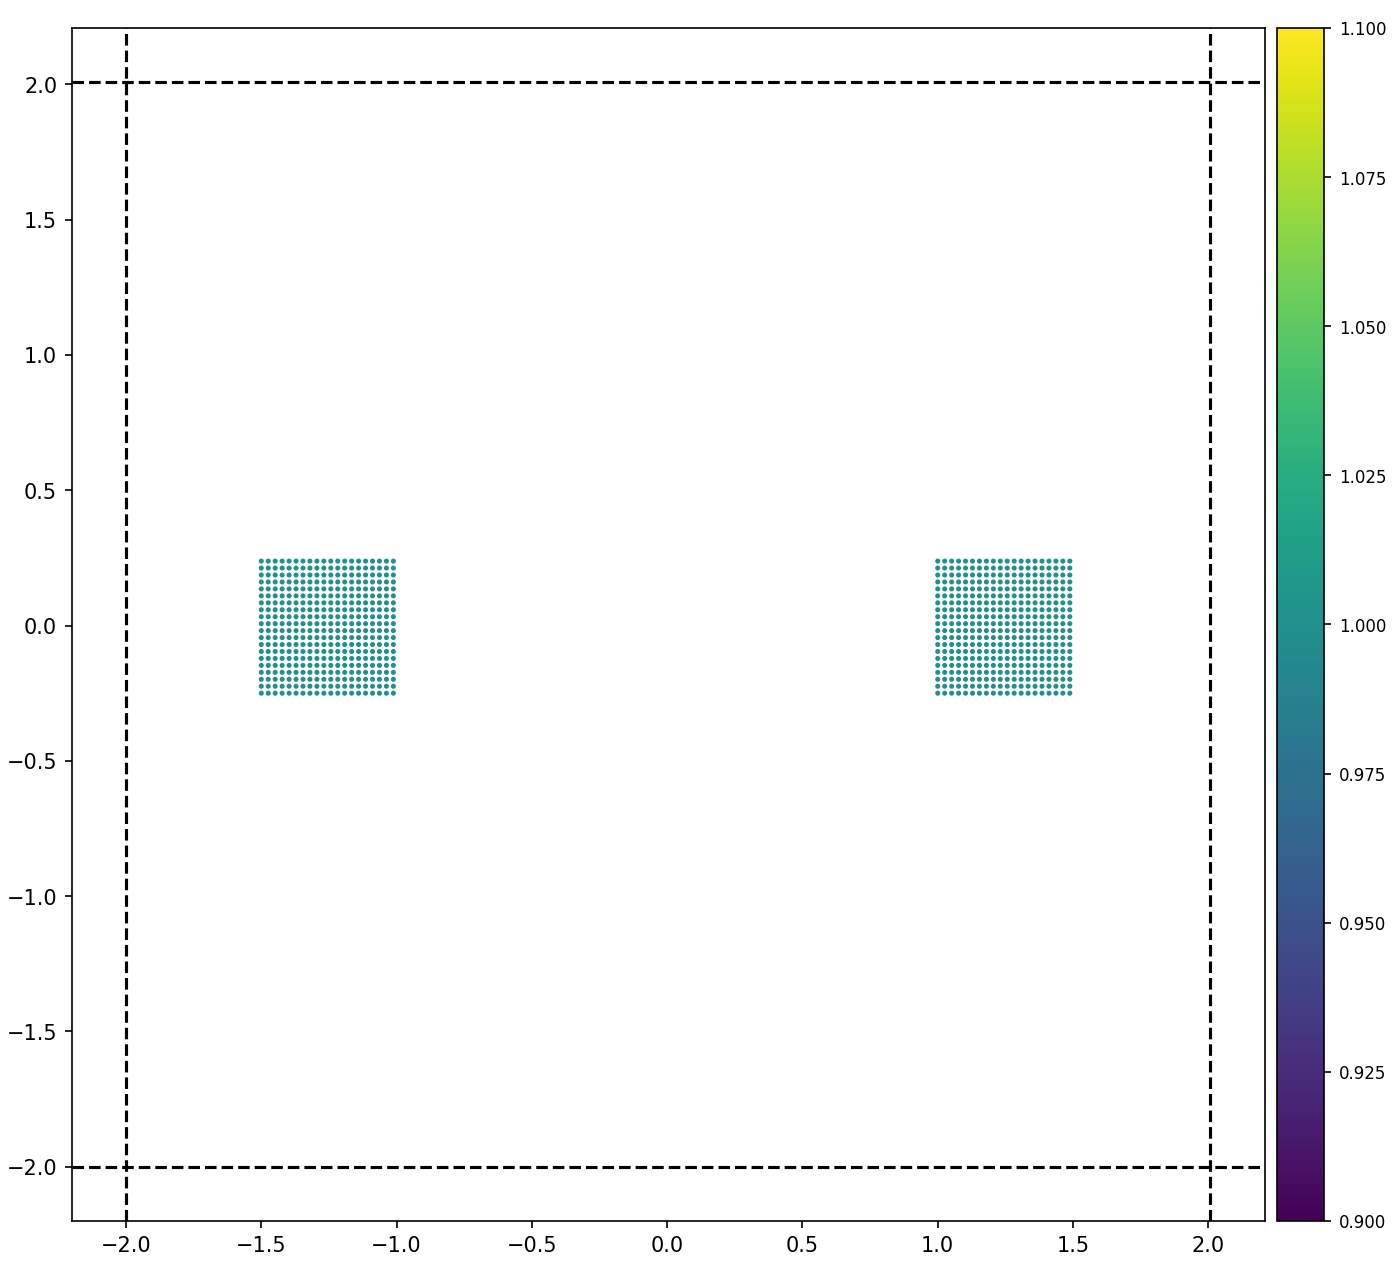

In [245]:
fig, axis = sphSimulation.createPlot(plotScale = 2)

positions = sphSimulation.simulationState['fluidPosition'].detach().cpu().numpy()
colors = torch.linalg.norm(sphSimulation.simulationState['fluidVelocity'].detach(),axis=1).cpu().numpy()


sc = axis[0,0].scatter(positions[:,0], positions[:,1], c = colors, s = 2)
axis[0,0].axis('equal')

ax1_divider = make_axes_locatable(axis[0,0])
cax1 = ax1_divider.append_axes("right", size="4%", pad="1%")
cbar = fig.colorbar(sc, cax=cax1,orientation='vertical')
cbar.ax.tick_params(labelsize=8) 

fig.tight_layout()